En este notebook construiremos un SVM de clasificación utilizando **scikit-learn** y el kernel **RBF (Radial Basis Function)**. Nuestro conjunto de datos de entrenamiento contiene datos continuos y categóricos del **UCI Machine Learning Repository** para predecir si un paciente tiene o no una enfermedad cardíaca. Debería llevaros aproximadamente 1h para completar.

**NOTA**: Este ejercicio asume que conoces los conceptos básicos de codificación en Python y estás familiarizado con la teoría detrás de las **SVM, RBF, Regularización, Validación Cruzada y Matrices de Confusión.**

In [1]:
import pandas as pd

A continuación haremos:



*   Importar datos de un archivo
*   Indentificar y tratar los missing values
*   Formatear datos para las SVM
*   Construír un  inicial
*   Utilizar Cross Validation para optimizar los parámetros del kernel
*   Construir, Evaluar, Dibujar e Interpretar una SVM final




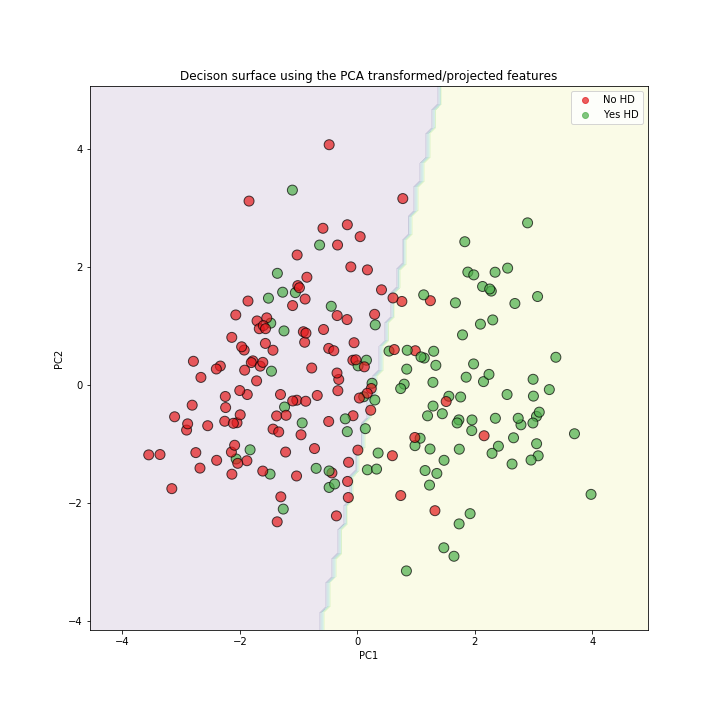

## Importamos los módulos que vamos a utilizar en el notebook

In [ ]:
# Importamos las librerías que vamos a utilizar para el siguiente notebook

import pandas as pd 
import numpy as np # para calcular la media y la desviación estándar
import matplotlib.pyplot as plt # gráficos
import matplotlib.colors as colors
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import scale # para centrar y escalar los datos
from sklearn.svm import SVC # Con esto haremos un SVM para clasificación
from sklearn.model_selection import GridSearchCV # Para hacer Cross Validation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Con esto creamos una matriz de confusión
from sklearn.decomposition import PCA # PCA es una técnica de reducción de dimensionalidad que encuentra nuevas variables no correlacionadas para conservar la información relevante de los datos originales.







---



## 2 - Importamos los datos

Cargamos el dataset desde **[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Heart+Disease)**. Este dataset nos permitira predecir si alguien tiene alguna enfermedad del corazón basado en su sex, edad, presión sanguínea y otras métricas

In [ ]:
#Cargamos los datos en un dataframe
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data', header=None)
#Visualizamos con la función head

df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [ ]:
df.columns

Index(['1 15943882 63 1 -9 -9 -9'], dtype='object')

Vemos que en lugar de nombres de columna bonitos, sólo tenemos números de columna. Dado que los nombres de columna agradables harían más fácil saber cómo dar formato a los datos, vamos a reemplazar los números de columna con los siguientes nombres de columna:

- **age**,
- **sex**,(1 = masculino; 0 = femenino)
- **cp**, chest pain(1 = subesternal; 0 = de otro modo)
- **trestbps**, presión arterial en reposo (en mm Hg)
- **chol**, colesterol en suero en mg/dl
- **fbs**, azúcar en sangre (ayunas)
- **restecg**, resultados electrocardiográficos en reposo
- **thalach**,  frecuencia cardiaca máxima alcanzada
- **exang**, angina inducida por el ejercicio ( 1=si, 2=no)
- **oldpeak**, Depresión del ST inducida por el ejercicio en relación con el reposo
- **slope**, la pendiente del segmento ST de ejercicio máximo
-- Valor 1: pendiente ascendente
-- Valor 2: plano
-- Valor 3: pendiente descendente
- **ca**, número de vasos mayores (0-3) coloreados por flouroscopia
- **thal**, escáner cardíaco de Talio
- **hd**, diagnóstico de ataque al corazón, la variable a Predecir.

In [ ]:
df.columns = ['age',
              'sex',
              'cp',
              'restbp',
              'chol',
              'fbs',
              'restecg',
              'thalach',
              'exang',
              'oldpeak',
              'slope',
              'ca',
              'thal',
              'hd']
df.head()


,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


## Tarea 3: Datos que faltan. Parte 1: Identificar 'Missing data'

Lamentablemente, la mayor parte de cualquier proyecto de análisis de datos consiste en asegurarse de que los datos están formateados correctamente y corregirlos cuando no es así. La primera parte de este proceso es lidiar con **Datos Perdidos**. (missing data)

Los **Missing values** son simplemente espacios en blanco o valores sustitutos que indican que no se han recogido datos para una de las características. Por ejemplo, si nos olvidamos de preguntar la edad de alguien, o nos olvidamos de anotarla, entonces tendríamos un espacio en blanco en el conjunto de datos para la **edad** de esa persona.

Hay dos formas principales de tratar los datos que faltan:
1. Podemos eliminar del conjunto de datos las filas que contienen datos que faltan. Esto es relativamente fácil de hacer, pero desperdicia todos los demás valores que hemos recogido. Como afecta al resultado, depende de la importancia del 'missing value' que falta para la clasificación. Por ejemplo, si nos falta un valor para **edad**, y **edad** no es útil para clasificar si las personas padecen una enfermedad cardiaca o no, entonces sería una pena desechar todos los datos de alguien sólo porque no tenemos su **edad**.
2. Podemos **imputar** los valores que faltan. En este contexto, **imputar** es una forma elegante de decir "podemos hacer una conjetura sobre cuál debería ser el valor". Continuando con nuestro ejemplo en el que falta un valor para **edad**, en lugar de desechar toda la fila de datos, podemos rellenar el valor que falta con la media de edad o la mediana de edad, o utilizar algún otro enfoque más sofisticado, para adivinar un valor apropiado.

En esta sección, nos centraremos en identificar los valores que faltan en el conjunto de datos y en tratar con ellos. 

En primer lugar, veamos qué tipo de datos hay en cada columna.

In [ ]:
##Completar

df.dtypes

age        float64
sex        float64
cp         float64
restbp     float64
chol       float64
fbs        float64
restecg    float64
thalach    float64
exang      float64
oldpeak    float64
slope      float64
ca          object
thal        object
hd           int64
dtype: object

Vemos que casi todas las columnas son `float64`, sin embargo, dos columnas, **ca** y **thal**, son del tipo `object` y una columna, **hd** es del tipo `int64`.

El hecho de que las columnas **ca** y **thal** tengan tipos de datos `object` sugiere que algo raro está pasando en ellas. Los tipos de datos `object` se usan cuando hay mezclas de cosas, como una mezcla de números y letras. En teoría, tanto **ca** como **thal** deberían tener sólo unos pocos valores que representen diferentes categorías, así que vamos a investigar qué está pasando motrando sus valores únicos. Empezaremos con ca:

In [ ]:
df.ca.unique()

array(['0.0', '3.0', '2.0', '1.0', '?'], dtype=object)

In [ ]:
df.ca.value_counts()

0.0    176
1.0     65
2.0     38
3.0     20
?        4
Name: ca, dtype: int64

Vemos que ca contiene números (0,0, 3,0, 2,0 y 1,0) y signos de interrogación (?). Los números representan el número de vasos sanguíneos que hemos iluminado por fluoroscopia y los signos de interrogación representan los datos que faltan.

Veamos ahora los valores únicos de thal.

In [ ]:
df.thal.unique()

array(['6.0', '3.0', '7.0', '?'], dtype=object)

In [ ]:
df.thal.value_counts()

2    544
3    410
1     64
0      7
Name: thal, dtype: int64

Una vez más, **thal** también contiene una mezcla de números, que representan los diferentes diagnósticos de la exploración cardíaca con talio, y signos de interrogación, que representan los valores que faltan.


---






# Tarea 4: Datos que faltan Parte 2: Tratar con 'Missing Values'

Dado que las SVM de scikit-learn no admiten conjuntos de datos con valores perdidos, tenemos que averiguar qué hacer con estos signos de interrogación. Podemos eliminar estos pacientes del conjunto de datos de entrenamiento o imputar valores para los datos que faltan. Primero veamos cuántas filas contienen valores perdidos.

In [ ]:
len(df.loc[(df['ca'] == '?') | (df['thal'] == '?')])


6

In [ ]:
df.ca.value_counts()

0.0    176
1.0     65
2.0     38
3.0     20
?        4
Name: ca, dtype: int64

Ya que solamente hay 6 filas con valores nules, vamos a echarles un vistazo

In [ ]:
df.loc[(df['ca'] == '?') | (df['thal'] == '?')]

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


Ahora vamos a contar el número de filas en todo el dataset


In [ ]:
df.shape

(303, 14)

Así que 6 de las **303** filas, o el **2%**, contienen valores perdidos. Como **303 - 6 = 297**, y 297 son datos suficientes para construir una SVM, eliminaremos las filas con missing values, en lugar de intentar imputar sus valores. Para ello, seleccionamos todas las filas que no contienen signos de interrogación en las columnas ca o thal:

In [ ]:
df_clean = df.loc[(df['ca'] != '?') & (df['thal'] != '?')]

Las matemáticas salen bien. Sin embargo, también podemos asegurarnos de que ca ya no contiene signos de interrogación imprimiendo sus valores únicos:

In [ ]:
df_clean['ca'].unique()

array(['0.0', '3.0', '2.0', '1.0'], dtype=object)

Podemos hacer lo mismo para thal:

In [ ]:
df_clean.thal.unique()

array(['6.0', '3.0', '7.0'], dtype=object)

Genial! Hemos verificado que df_clean no contiene missing values. 

Importante:  **ca** y thal **siguen** teniendo el tipo de datos `object`. No pasa nada. Ahora estamos listos para formatear los datos para hacer una SVM

---



## Tarea 5: Dar formato datos - Parte 1: Dividir los Datos en Variables Dependientes e Independientes

Ahora que nos hemos ocupado de los datos que faltaban, estamos listos para empezar a limpiar los datos para hacer una **Support Vector Machine**.

El primer paso es dividir los datos en dos partes:
1. Las columnas de datos que utilizaremos para hacer las clasificaciones
2. La columna de datos que queremos predecir.

Utilizaremos la notación convencional `X` (mayúsculas **X**) para representar las columnas de datos que utilizaremos para hacer clasificaciones y `y` (minúsculas **y**) para representar lo que queremos predecir. En este caso, queremos predecir **hd** (heart disease).

**NOTA:** En el código de abajo estamos usando `copy()` para copiar los datos *por valor*. Por defecto, pandas usa copia *por referencia*. Usar `copy()` asegura que el dato original `df_clean` no se modifica cuando modificamos `X` o `y`. En otras palabras, si cometemos un error al formatear las columnas para las máquinas de vectores soporte, podemos simplemente volver a copiar `df_clean`, en lugar de tener que recargar los datos originales y eliminar los valores perdidos, etc.

In [ ]:
X = df_clean.drop('hd', axis=1).copy()
X.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0


In [ ]:
y = df_clean['hd'].copy()
y.head()


0    0
1    2
2    1
3    0
4    0
Name: hd, dtype: int64

# Tarea 6: Formatear los datos - Parte 2: One-Hot Encoding

Ahora que hemos dividido el dataset en dos partes, `X`, que contiene los datos que utilizaremos para hacer, o predecir, clasificaciones, e `y`, que contiene las clasificaciones conocidas en nuestro conjunto de datos de entrenamiento, tenemos que echar un vistazo más de cerca a las variables en `X`. La siguiente lista nos indica lo que representa cada variable y el tipo de datos (**float** o **categorical**) que debe contener:

- **age**, **Float**
- **sex** - **Category**
  - 0 = mujer
  - 1 = hombre
- **cp**, dolor torácico, **Category**
  - 1 = angina típica
  - 2 = angina atípica,
  - 3 = dolor no anginoso,
  - 4 = asintomático
- **restbp**, presión arterial en reposo (en mm Hg), **Float**
- **chol**, colesterol sérico en mg/dl, **Float**
- **fbs**, glucemia en ayunas, **Category**
  - 0 = >=120 mg/dl
  - 1 = <120 mg/dl
- **restecg**, resultados del electrocardiograma en reposo, **Category**
  - 1 = normal
  - 2 = con anomalía de la onda ST-T
  - 3 = con hipertrofia ventricular izquierda probable o definida
- **thalach**, frecuencia cardiaca máxima alcanzada, **Float**
- **exang**, angina inducida por el ejercicio, **Category**
  - 0 = no
  - 1 = sí
- **oldpeak**, depresión del ST inducida por el ejercicio en relación con el reposo. **Float**
- **slope**, pendiente del segmento ST máximo durante el ejercicio, **categoría**.
  - 1 = pendiente ascendente
  - 2 = plano
  - 3 = pendiente descendente
- **Ca**, número de vasos principales (0-3) coloreados por fluoroscopia, **Float**.
- **thal**, gammagrafía cardíaca con talio, **Categoría**
  - 3 = normal (sin puntos fríos)
  - 6 = defecto fijo (puntos fríos durante el reposo y el ejercicio)
  - 7 = defecto reversible (cuando los puntos fríos sólo aparecen durante el ejercicio)

Ahora, sólo para recapitular, vamos a ver los tipos de datos en `X` para recordar cómo python está viendo los datos en este momento.

In [ ]:
X.dtypes


age        float64
sex        float64
cp         float64
restbp     float64
chol       float64
fbs        float64
restecg    float64
thalach    float64
exang      float64
oldpeak    float64
slope      float64
ca          object
thal        object
dtype: object

Así, vemos que **age**, **restbp**, **chol** y **thalach** son todos `float64`, lo cual es bueno, porque queremos que sean números en coma flotante. Todas las demás columnas, sin embargo, necesitan ser inspeccionadas para asegurarnos de que sólo contienen valores razonables, y algunas de ellas necesitan cambiar. Esto se debe a que, mientras que **scikit learn Support Vector Machines** soporta de forma nativa datos continuos, como la presión sanguínea en reposo (**restbp**) y la frecuencia cardíaca máxima (**thalach**), no soporta de forma nativa datos categóricos, como el dolor torácico (**cp**), que contiene 4 categorías diferentes. Por lo tanto, para utilizar datos categóricos con **scikit learn Support Vector Machines**, tenemos que utilizar un truco que convierte una columna de datos categóricos en múltiples columnas de valores binarios. Este truco se llama **One-Hot Encoding**.

Llegados a este punto te estarás preguntando: "¿qué hay de malo en tratar los datos categóricos como datos continuos?". Para responder a esa pregunta, veamos un ejemplo: Para la columna **cp** (dolor torácico), tenemos 4 opciones:
1. angina típica
2. angina atípica
3. dolor no anginoso,
4. asintomático

Si tratáramos estos valores, 1, 2, 3 y 4, como datos continuos, supondríamos que 4, que significa "asintomático", es más similar a 3, que significa "dolor no anginoso", que a 1 o 2, que son otros tipos de dolor torácico. Por tanto, la SVM agruparía con mayor probabilidad a los pacientes con 4 y 3 juntos que a los pacientes con 4 y 1 juntos. Por el contrario, si tratamos estos números como datos categóricos, entonces tratamos cada uno como una categoría separada que no es ni más ni menos similar a ninguna de las otras categorías. Así, la probabilidad de agrupar a los pacientes con 4s con 3s es la misma que agrupar a los 4s con 1s, y ese enfoque es más razonable.

Ahora vamos a inspeccionar y, si es necesario, convertir las columnas que contienen datos categóricos y enteros en los tipos de datos correctos. Empezaremos con **cp** (dolor en el pecho) inspeccionando todos sus valores únicos:


In [ ]:
X.cp.unique()

array([1., 4., 3., 2.])

Así pues, la buena noticia es que **cp** sólo contiene los valores que se supone que debe contener, por lo que lo convertiremos, utilizando **One-Hot Encoding**, en una serie de columnas que sólo contengan **0s** y **1s**.

<!-- Ahora tenemos que tratar con **cp** (dolor torácico), **restecg** (resultados electrocardiográficos en reposo), **slope** (la pendiente del pico del segmento ST de ejercicio) y **thal** (escáner cardíaco de talio).
 -->
Hay muchas maneras diferentes de hacer **One-Hot Encoding** en Python. Dos de los métodos más populares son `ColumnTransformer()` (de **scikit-learn**) y `get_dummies()` (de **pandas**), y ambos métodos tienen pros y contras. `ColumnTransformer()` tiene una característica muy interesante: crea una función persistente que puede validar los datos que obtengas en el futuro. Por ejemplo, si construyes tu **SVM** usando una variable categórica **color favorito** que tiene opciones **rojo**, **azul** y **verde**, entonces `ColumnTransformer()` puede recordar esas opciones y más tarde cuando tu **SVM** esté siendo usada en un sistema de producción, si alguien dice que su color favorito es **naranja**, entonces `ColumnTransformer()` puede lanzar un error o manejar la situación de alguna otra forma. La desventaja de `ColumnTransformer()` es que convierte los datos en un array y pierde todos los nombres de las columnas, haciendo más difícil verificar que el uso de `ColumnTransformer()` funcionó como se pretendía. Por el contrario, `get_dummies()` deja los datos en un dataframe y conserva los nombres de las columnas, por lo que es mucho más fácil verificar que funcionó según lo previsto. Sin embargo, no tiene el comportamiento persistente que tiene `ColumnTransformer()`. Así que, para aprender cómo funciona **One-Hot Encoding**, vamos a usar `get_dummies()`. Sin embargo, una vez que te sientas cómodo con **One-Hot Encoding**, te animo a investigar el uso de `ColumnTransformer()`.

Primero, antes de comprometernos a convertir **cp** en **One-Hot Encoding**, vamos a ver que pasa cuando convertimos **cp** sin guardar los resultados. Esto nos facilitará ver cómo funciona `get_dummies()`.

In [ ]:
pd.get_dummies(X,columns = ['cp']).head()


,age,sex,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,cp_1.0,cp_2.0,cp_3.0,cp_4.0
0,63.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,1,0,0,0
1,67.0,1.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,0,0,0,1
2,67.0,1.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,0,0,0,1
3,37.0,1.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,1,0
4,41.0,0.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,1,0,0


Como podemos ver en la impresión anterior, `get_dummies()` pone todas las columnas que no procesa al principio y pone **cp** al final. También divide **cp** en **4** columnas, tal y como esperábamos. **cp_1.0** es `1` para cualquier paciente que haya obtenido un **1** en dolor torácico y `0` para todos los demás pacientes. **cp_2.0** es `1` para cualquier paciente que haya puntuado **2** en dolor torácico y `0` para todos los demás pacientes. **cp_3.0** es `1` para cualquier paciente que haya puntuado **3** en dolor torácico y **cp_4.0** es `1` para cualquier paciente que haya puntuado **4** en dolor torácico.

Ahora que vemos cómo funciona `get_dummies()`, vamos a utilizarlo en las cuatro columnas categóricas que tienen más de 2 categorías y guardar el resultado.

**NOTA:** En la práctica debes verificar las 5 columnas para asegurarte de que sólo contienen las categorías aceptadas.


In [ ]:
X_encoded = pd.get_dummies(X, columns = ['cp', 'restecg', 'slope', 'thal'])

X_encoded.head()

,age,sex,restbp,chol,fbs,thalach,exang,oldpeak,ca,cp_1.0,...,cp_4.0,restecg_0.0,restecg_1.0,restecg_2.0,slope_1.0,slope_2.0,slope_3.0,thal_3.0,thal_6.0,thal_7.0
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,1,...,0,0,0,1,0,0,1,0,1,0
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,3.0,0,...,1,0,0,1,0,1,0,1,0,0
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,0,...,1,0,0,1,0,1,0,0,0,1
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,0,...,0,1,0,0,0,0,1,1,0,0
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,0,...,0,0,0,1,1,0,0,1,0,0


Ahora tenemos que hablar de las **3** columnas categóricas que sólo contienen **0**s y **1**s: **sex**, **fbs** (glucemia en ayunas) y **exang** (exercise induced angina). Como podemos ver, **One-Hot Encoding** convierte una columna con más de **2** categorías, como **cp** (chest pain) en múltiples columnas de **0**s y **1**s. Dado que **sex**, **fbs**, y **exang** sólo tienen **2** categorías y sólo contienen **0**s y **1**s para empezar, no tenemos que hacer nada especial con ellos, así que hemos terminado de formatear los datos para la **SVM**.

**NOTA:** En la práctica usaríamos `unique()` para verificar que sólo contienen **0**s y **1**s, pero para ahorrar tiempo... ¡confía en mí!

**Importante**

Ahora, una última cosa antes de construir una Support Vector Machine. `y` no sólo contiene **0**s y **1**s. En su lugar, tiene **5 niveles diferentes de enfermedad cardíaca. 0 = sin enfermedad cardíaca y 1-4 son varios grados de enfermedad cardíaca. Podemos ver esto con unique():

In [ ]:
y.unique()


array([0, 2, 1, 3, 4])

Como sólo estamos haciendo una SVM que hace una clasificación simple y sólo nos importa si alguien tiene una enfermedad cardíaca o no, necesitamos convertir todos los números **> 0** a 1.

In [ ]:
y_not_zero = y>0
y[y_not_zero] = 1
y.unique()

array([0, 1])

Por fin hemos terminado de formatear los datos para hacer una Support Vector Machine, así que ¡¡¡hagámoslo!!!

## Tarea 7: Formatear los datos Parte 3: Centrar y escalar

La **Función de Base Radial (RBF)** que estamos utilizando con nuestra **Support Vector Machine** asume que los datos están centrados y escalados, por lo que necesitamos hacer esto tanto en los conjuntos de datos de train como en los de test.

**NOTA:** Dividimos los datos en conjuntos de entrenamiento y prueba y luego los escalamos por separado para evitar **Data Leakage **. **La fuga de datos** se produce cuando la información sobre el conjunto de datos de entrenamiento interrumpe o influye en el conjunto de datos de prueba.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)


In [ ]:
X_train.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
66,60.0,1.0,3.0,140.0,185.0,0.0,2.0,155.0,0.0,3.0,2.0,0.0,3.0
105,54.0,1.0,2.0,108.0,309.0,0.0,0.0,156.0,0.0,0.0,1.0,0.0,7.0
160,46.0,1.0,2.0,101.0,197.0,1.0,0.0,156.0,0.0,0.0,1.0,0.0,7.0
147,41.0,1.0,3.0,112.0,250.0,0.0,0.0,179.0,0.0,0.0,1.0,0.0,3.0
19,49.0,1.0,2.0,130.0,266.0,0.0,0.0,171.0,0.0,0.6,1.0,0.0,3.0


## Tarea 8: Construir una SVM preliminar

Por fin, los datos están formateados correctamente para crear una SVM

In [ ]:
clf_svm = SVC(random_state = 42)
clf_svm.fit(X_train_scaled, y_train)

SVC(random_state=42)

Bien, hemos construido una **Support Vector Machine** para la clasificación. Vamos a ver cómo se desempeña en el conjunto de datos de test y dibujar una **matriz de confusión.**

In [ ]:
cm = confusion_matrix(y_test, clf_svm.predict(X_test_scaled), labels=clf_svm.classes_)
cm

array([[37,  5],
       [ 5, 28]])

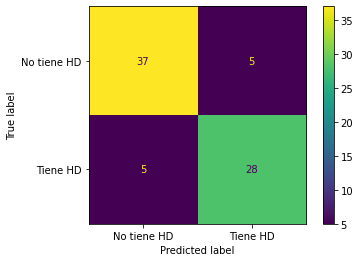

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No tiene HD", "Tiene HD"])
disp.plot()

En la matriz de confusión, vemos que de las **37 + 5 = 42** personas que no tenían **enfermedad cardiaca**, **37 (88%)** fueron clasificadas correctamente. Y de las **5 + 28 = 33** personas con **enfermedad cardiaca**, **28 (85%)** fueron clasificadas correctamente. Así que la máquina de vectores soporte lo hizo bastante bien sin ninguna optimización. Dicho esto, es posible que podamos mejorar las predicciones utilizando **Cross Validation** para optimizar los parámetros.

# Tarea 9: Optimizar parámetros con validación cruzada

Optimizar una **SVM** consiste en encontrar el mejor valor para **gamma**, y, potencialmente, el parámetro de regularización, **C**. Así que vamos a ver si podemos encontrar mejores parámetros utilizando cross validation con la esperanza de que podamos mejorar la precisión con el **Testing Dataset**.

Como tenemos que optimizar dos parámetros, utilizaremos `GridSearchCV()`. Hacemos esto especificando valores potenciales para **gamma** y **C**, y `GridSearchCV()` prueba todas las combinaciones posibles de los parámetros para nosotros.

In [ ]:
param_grid = [
    {'C': [1, 10, 100,1000],
    'gamma': [0.001, 0.0001],
    'kernel': ['rbf']},
]

optimal_params = GridSearchCV(SVC(), param_grid, cv=5, verbose = 0)

optimal_params.fit(X_train_scaled, y_train)
optimal_params.best_params_


{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

Y vemos que el valor ideal para C es **10** y el valor ideal para gamma es **0,001.**

# Tarea 10: Construir, evaluar, dibujar e interpretar la SVM final

Ahora que tenemos los valores ideales para `C` y `gamma` podemos construir la **SVM** final:

In [ ]:
clf_svm = SVC(random_state = 42, C=10, gamma=0.001)
clf_svm.fit(X_train_scaled, y_train)


SVC(C=10, gamma=0.001, random_state=42)

Volvamos a realizar otra matriz de confusión para ver si la optimización de la SVM lo hace mejor

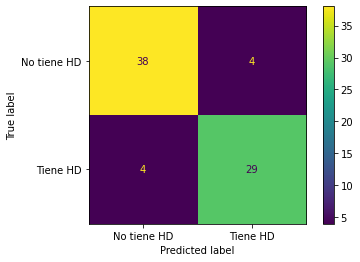

In [ ]:
cm = confusion_matrix(y_test, clf_svm.predict(X_test_scaled), labels=clf_svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No tiene HD", "Tiene HD"])
disp.plot()


¡¡¡Excelente!!! Vemos que la **SVM** optimizada clasifica mejor a los pacientes que la SVM preliminar. 

De las **38 + 4 = 42** personas que no tenían cardiopatía, **38 (90%)** fueron clasificadas correctamente. Esto supone una mejora respecto a la máquina de vectores soporte preliminar, que sólo clasificó correctamente a **37 (88%)** de los pacientes sin cardiopatía. De las **4 + 29 = 33** personas con cardiopatía, **29 (87%)** se clasificaron correctamente. Esto también supone una mejora con respecto a la máquina de vectores soporte preliminar, que sólo clasificó correctamente a **28 (85%)** de los pacientes con cardiopatías. Todo esto gracias a la optimización de los parámetros :)

Lo último que vamos a hacer es mostrar el 'decision boundary' optimizado de la SVM y discutir cómo interpretarlo.

Lo primero que tenemos que hacer es contar el número de columnas en **X**:

In [ ]:
len(df.columns)


14

Así, vemos que hay **14** características, o columnas, en **X**. 
Esto es un problema, porque para representar los datos  se necesitaría un gráfico de 14 dimensiones, una dimensión por cada característica utilizada para hacer predicciones. Si quisiéramos, podríamos elegir dos características al azar para usarlas como ejes x e y en nuestro gráfico, pero en lugar de eso, usaremos **PCA** (Análisis de Componentes Principales) para combinar las **14** características en **2** meta-características ortogonales que podemos usar como ejes para un gráfico. Todavía no conoces el PCA, pero NO te preocupes. Por ahora, basta con saber que es una forma de reducir un gráfico de 14 dimensiones a un gráfico de 2 dimensiones.

Sin embargo, antes de reducir el gráfico, vamos a determinar la precisión del gráfico reducido. Si es relativamente preciso, entonces tiene sentido dibujar el gráfico bidimensional. Si no, el gráfico reducido no será muy útil. Podemos determinar la exactitud de la gráfica dibujando algo llamado **trazado scree**.

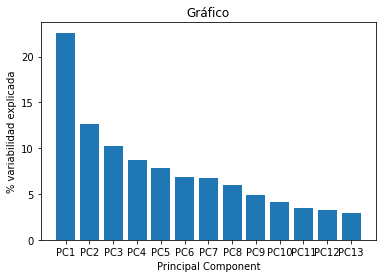

In [ ]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
 
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('% variabilidad explicada')
plt.xlabel('Principal Component')
plt.title('Gráfico')
plt.show()

El gráfico de pantalla muestra que el primer componente principal, **PC1**, representa una cantidad relativamente grande de variación en los datos, lo que significa que será un buen candidato para el eje x en el gráfico bidimensional. Dado que PC2 representa la siguiente mayor cantidad de varianza, lo utilizaremos para el eje y.

Ahora dibujaremos el gráfico PCA. NOTA: Este código es bastante técnico, pero no tenemos que escribirlo y hay comentarios que explican cada paso.

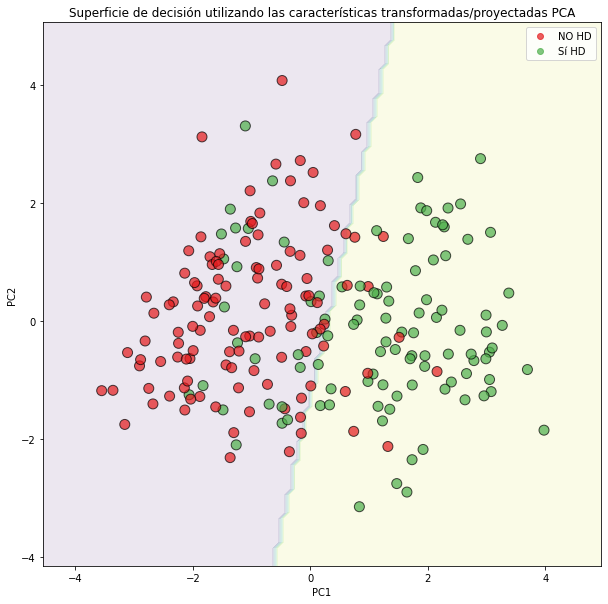

In [ ]:
pc1 = X_train_pca[:, 0] 
pc2 = X_train_pca[:, 1]

## NOTA:
## pc1 contiene las coordenadas del eje x de los datos después de PCA
## pc2 contiene las coordenadas del eje y de los datos después de PCA

## Ahora ajustamos el SVM a las coordenadas del eje x e y
## de los datos después de la reducción de dimensionalidad PCA...
clf_svm.fit(np.column_stack((pc1, pc2)), y_train)

## Ahora creamos una matriz de puntos que podemos usar para mostrar
## las regiones de decisión.
## La matriz será un poco más grande que los
## puntos PCA transformados para que podamos graficar todos los
## puntos PCA en ella sin que estén en el borde
x_min = pc1.min() - 1
x_max = pc1.max() + 1

y_min = pc2.min() - 1
y_max = pc2.max() + 1

xx, yy = np.meshgrid(np.arange(start=x_min, stop=x_max, step=0.1),
                     np.arange(start=y_min, stop=y_max, step=0.1))

## ahora clasificaremos cada punto en ese
## matriz con el SVM. Los puntos a un lado del
## límite de clasificación obtendrán 0, y los puntos en el otro
## lado obtendrán 1.
Z = clf_svm.predict(np.column_stack((xx.ravel(), yy.ravel())))
## Ahora, Z es solo una matriz larga de muchos 0s y 1s, que
## refleja cómo se clasificó cada punto en la malla.
## Usamos reshape() para que cada clasificación (0 o 1) corresponda
## a un punto específico en la matriz.
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(10,10))
## ahora usaremos contourf() para dibujar un gráfico de contorno lleno
## usando los valores de la matriz y las clasificaciones.
## Los contornos se llenarán de acuerdo con las
## clasificaciones predichas (0s y 1s) en Z
ax.contourf(xx, yy, Z, alpha=0.1)

## ahora creamos colores personalizados para los puntos de datos reales
cmap = colors.ListedColormap(['#e41a1c', '#4daf4a'])
## ahora dibuja los puntos de datos reales: estos serán
## coloreados por sus clasificaciones conocidas (no predichas)
## NOTA: establecer alpha=0.7 nos permite ver si estamos cubriendo un punto
scatter = ax.scatter(pc1, pc2, c=y_train, 
               cmap=cmap, 
               s=100, 
               edgecolors='k', ## 'k' = negro
               alpha=0.7)

## ahora crea una leyenda
legend = ax.legend(scatter.legend_elements()[0], 
                   scatter.legend_elements()[1],
                    loc="upper right")
legend.get_texts()[0].set_text("NO HD")
legend.get_texts()[1].set_text("Sí HD")

## añade ahora etiquetas y títulos a los ejes
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_title('Superficie de decisión utilizando las características transformadas/proyectadas PCA')
# plt.savefig('svm.png')
plt.show()

# ✅

El lado rosa del gráfico de la izquierda es el área en la que se predice que todos los puntos de datos *no* padecen enfermedades cardíacas. El lado amarillo del gráfico de la derecha es el área en la que se predice que todos los puntos de datos *tienen* una cardiopatía. Los puntos son puntos de datos del conjunto de datos de entrenamiento y están codificados por colores según sus clasificaciones conocidas: el rojo corresponde a los que *no tienen* una cardiopatía y el verde a los que *tienen* una cardiopatía.